In [18]:
import pandas as pd
from pandas.io.json import json_normalize
import json
import boto3
import pandas as pd
import os.path
from os import path

s3 = boto3.resource('s3')
s3_client = boto3.client('s3')

def download(bucket, data_key):
    if path.exists(data_key):
        print('File '+data_key+' existed.')
        return False
    else:
        s3.Object(bucket, data_key).download_file(data_key)
        print('File '+data_key+' downloaded.')
        return True

In [20]:
bucket = 'wp-dw-sandbox'
url_prefix = 'yuy/tmp_yuy_30_mins_comments_dataset_rnn_v1/'
!mkdir $url_prefix
for obj in s3_client.list_objects(Bucket = bucket, Prefix = url_prefix)['Contents']:
#     filename, file_extension = os.path.splitext(obj['Key'])
    data_key = obj['Key']
    if '/.' in data_key:
        continue
    download(bucket, data_key)

mkdir: cannot create directory ‘yuy/tmp_yuy_30_mins_comments_dataset_rnn_v1/’: File exists
File yuy/tmp_yuy_30_mins_comments_dataset_rnn_v1/000000_0 existed.


In [21]:
# load the data
import dask.dataframe as dd
names = ['action_counts_dontagree','action_counts_like','action_counts_flag','action_counts_flag_banned_word','action_counts_flag_body_count','action_counts_flag_comment_noagree','action_counts_flag_comment_offensive','action_counts_flag_comment_other','action_counts_flag_comment_spam','action_counts_flag_matched_suspect_word_filter','action_counts_flag_suspect_word','action_counts_flag_trust','created_at','root_id','level','polarity_scores_compound','polarity_scores_neg','polarity_scores_neu','polarity_scores_pos','readability_flesch_kincaid_grade','readability_gunning_fog','readability_automated_readability_index','readability_coleman_liau_index','readability_sentence_count','readability_lexicon_count','readability_char_count','readability_sentence_avg_length','readability_lexicon_avg_length','created_at_day_of_week','created_at_hour_of_day','post_gap','thread_reply_count']
df = dd.read_csv(url_prefix+'*', sep='\01', header=None, names=names)
df = df.compute()

In [22]:
# category to one-hot vector
df.shape
columnsToEncode = pd.Series(['level', 'created_at_day_of_week', 'created_at_hour_of_day'])
X = pd.get_dummies(df, columns=columnsToEncode)
X.shape

(10369666, 66)

In [23]:
# housekeeping
X = X.drop(['created_at'], axis=1)
X = X.reindex(columns=(['thread_reply_count'] + list([a for a in X.columns if a != 'thread_reply_count']) ))
X = X.reindex(columns=(['root_id'] + list([a for a in X.columns if a != 'root_id']) ))

In [24]:
# normalization
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
cl = X.columns.values
cl = filter(lambda c: c != 'root_id' and c != 'thread_reply_count', cl)
cl = list(cl)
X[cl] = scaler.fit_transform(X[cl])

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [25]:
# for group,x in X.groupby('root_id'):
#     print(group)
#     print(x.values[0,1])
#     break
import numpy as np
data_x = [x.values[:,2:] for group,x in X.groupby('root_id')]
data_y = [x.values[0,1] for group,x in X.groupby('root_id')]

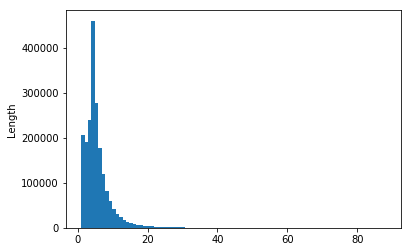

In [14]:
lens = [len(l) for l in data_x]
import matplotlib.pyplot as plt
plt.hist(lens, bins=max(lens))
plt.ylabel('Length');
plt.show()

In [29]:
# pad and keep the first n replies in each thread
def padding_series(ll, max_len):
    for i in range(len(ll)):
        if len(ll[i]) >= max_len:
            ll[i] = ll[i][:max_len]
        else:
            pads = [[0 for j in range(len(ll[i][0]))] for i in range(max_len-len(ll[i]))]
            ll[i] = np.concatenate((ll[i], pads), axis=0)

padding_series(data_x, 20)

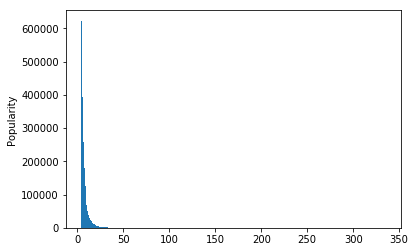

In [26]:
import matplotlib.pyplot as plt
plt.hist(data_y, bins=int(max(data_y)))
plt.ylabel('Popularity');
plt.show()

In [27]:
k = 40
data_y = [1 if y >= k else y/k for y in data_y]

In [28]:
data_x = np.array(data_x, dtype='float32')
data_y = np.array(data_y, dtype='float32')

In [29]:
np.save('data_x', data_x)
np.save('data_y', data_y)